# Description of the dataset:

We are given with three datasets:
1. Sales data: Data about sales
2. Sensor stock levels: Estimated stock levels of products based on IoT sensors
3. Sensor stock temperature:  IoT data from the temperature sensors in the storage facility for the products

# Objective:
Build models to check if we can predict the stock levels of products based on sales data and sensor data on an hourly basis inorder to help the client procure products from their suppliers. 

In [2]:
# Importing all the libraries that are required:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings(action = 'ignore')

- We have 3 files here. Instead of reading them separately, we can use glob module.
- glob.glob is a function in the Python glob module that returns a list of files or directories that match a specified pattern.
- "*.csv" will match all the files in the current directory that have a ".csv" file extension.

In [3]:
file_list = glob.glob('*.csv')  # * to see all the files ending with .csv
file_list

['sales.csv', 'sensor_stock_levels.csv', 'sensor_storage_temperature.csv']

In [4]:
data = {name.split('.')[0]:pd.read_csv(name) for name in file_list}   # to extract only names 

In [5]:
data.keys()

dict_keys(['sales', 'sensor_stock_levels', 'sensor_storage_temperature'])

In [6]:
data['sales'].head(3)

,Unnamed: 0,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:51:38,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:33:59,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet
2,2,ae133534-6f61-4cd6-b6b8-d1c1d8d90aea,2022-03-04 17:20:21,7c55cbd4-f306-4c04-a030-628cbe7867c1,fruit,premium,0.19,2,0.38,e-wallet


Dropping the column - 'Unnamed: 0'

In [7]:
data['sales'].drop(columns = 'Unnamed: 0', inplace = True)

In [8]:
data['sensor_stock_levels'].drop(columns = 'Unnamed: 0', inplace = True)

In [9]:
data['sensor_storage_temperature'].drop(columns = 'Unnamed: 0', inplace = True)

To check if there are any null/missing data, to see how many columns and rows are present and  to know the data type of each column present in the DataFrame, we can use .info() method

In [10]:
data['sales'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB


In [11]:
data['sensor_stock_levels'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2   product_id           15000 non-null  object 
 3   estimated_stock_pct  15000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 468.9+ KB


In [12]:
data['sensor_storage_temperature'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           23890 non-null  object 
 1   timestamp    23890 non-null  object 
 2   temperature  23890 non-null  float64
dtypes: float64(1), object(2)
memory usage: 560.0+ KB


- There are no null values, the only issue is with the timestamp column.
- The data type for this column is string, it is essential to convert it to timestamp for further analysis.


In [13]:
# Converting to datetime datatype:

data['sales']['timestamp']  = pd.to_datetime(data['sales']['timestamp'], errors = 'coerce') # if there is non numeric type, coerce will set as NaN
data['sensor_stock_levels']['timestamp'] = pd.to_datetime(data['sensor_stock_levels']['timestamp'],errors = 'coerce')
data['sensor_storage_temperature']['timestamp'] = pd.to_datetime(data['sensor_storage_temperature']['timestamp'],errors = 'coerce')

In [14]:
  data['sales']['timestamp'] 

0      2022-03-02 09:51:38
1      2022-03-06 10:33:59
2      2022-03-04 17:20:21
3      2022-03-02 17:23:58
4      2022-03-05 14:32:43
               ...        
7824   2022-03-03 18:22:09
7825   2022-03-04 19:14:46
7826   2022-03-03 14:00:09
7827   2022-03-04 15:11:38
7828   2022-03-06 13:50:36
Name: timestamp, Length: 7829, dtype: datetime64[ns]

In [15]:
data['sensor_storage_temperature'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23890 entries, 0 to 23889
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           23890 non-null  object        
 1   timestamp    23890 non-null  datetime64[ns]
 2   temperature  23890 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 560.0+ KB


Now the analysis on timestamp column is much easier as we have converted it to datatime format.

# Merging the data
- Inorder to merge the data we have only timestamp column that is common in all the three datasets
- But the time is varying in few minutes between all the 3 datasets.
- Inorder to merge the data and analyse, we need to convert the timestamp to hourly basis.
- For eg: If the time in 
sales data : 09:51:38,
sensor stock levels: 09:36:46,
sensoor storage temperature: 09:22:04, is in this format
- If we can convert the time to hourly basis and if all three timestamp shows 09:00:00, we can easily merge the datasets


In [16]:
# To convert all the time in hourly basis

def convert_timestamp_to_hourly(data, column):
    dummy = data.copy() # copying the data to a dummy variable
    new_ts = dummy[column].tolist() # here the column is timestamp.
   
    new_ts = [i.strftime('%Y-%m-%d %H:00:00') for i in new_ts] # to convert time to H:00:00 minutes
    
    dummy[column] = new_ts
    return dummy

In [17]:
data['sales'] = convert_timestamp_to_hourly(data['sales'],'timestamp')
data['sensor_stock_levels'] = convert_timestamp_to_hourly(data['sensor_stock_levels'], 'timestamp')
data['sensor_storage_temperature'] = convert_timestamp_to_hourly(data['sensor_storage_temperature'], 'timestamp')

In the below table, we can see that the time has changed and the minutes,seconds are all zeros

In [18]:
data['sensor_stock_levels'].head(4)

,id,timestamp,product_id,estimated_stock_pct
0,4220e505-c247-478d-9831-6b9f87a4488a,2022-03-07 12:00:00,f658605e-75f3-4fed-a655-c0903f344427,0.75
1,f2612b26-fc82-49ea-8940-0751fdd4d9ef,2022-03-07 16:00:00,de06083a-f5c0-451d-b2f4-9ab88b52609d,0.48
2,989a287f-67e6-4478-aa49-c3a35dac0e2e,2022-03-01 18:00:00,ce8f3a04-d1a4-43b1-a7c2-fa1b8e7674c8,0.58
3,af8e5683-d247-46ac-9909-1a77bdebefb2,2022-03-02 14:00:00,c21e3ba9-92a3-4745-92c2-6faef73223f7,0.79


Now we have timestamp that can be matched with all the 3 datasets and merged.

In [19]:
# For sales data: grouping by timestamp, using aggregate function 'sum' to sum up all the values of quantiy column and then reindedxing the dataframe..

sales = data['sales'].groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
sales.head()

,timestamp,product_id,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,3
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,3
2,2022-03-01 09:00:00,03a2557a-aa12-4add-a6d4-77dc36342067,3
3,2022-03-01 09:00:00,049b2171-0eeb-4a3e-bf98-0c290c7821da,7
4,2022-03-01 09:00:00,04da844d-8dba-4470-9119-e534d52a03a0,11


In [20]:
# For sensor stock levels data: grouping by timestamp and product id, using aggregate function 'mean' to take average of all the estimated stock product and then reindedxing the dataframe
stock = data['sensor_stock_levels'].groupby(['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
stock.head()

,timestamp,product_id,estimated_stock_pct
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05


In [21]:
# For sensor storage temperature: grouping by timestamp, using aggregate function 'mean' to take average of all the temperatures and then reindedxing the dataframe
temperature = data['sensor_storage_temperature'].groupby(['timestamp']).agg({'temperature': 'mean'}).reset_index()
temperature.head()

,timestamp,temperature
0,2022-03-01 09:00:00,-0.028850
1,2022-03-01 10:00:00,1.284314
2,2022-03-01 11:00:00,-0.560000
3,2022-03-01 12:00:00,-0.537721
4,2022-03-01 13:00:00,-0.188734


In [22]:
merged = stock.merge(sales, on = ['timestamp', 'product_id'], how = 'left')
merged

,timestamp,product_id,estimated_stock_pct,quantity
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN
...,...,...,...,...
10840,2022-03-07 19:00:00,ecac012c-1dec-41d4-9ebd-56fb7166f6d9,0.50,4.0
10841,2022-03-07 19:00:00,ed7f6b14-67c9-42a4-8576-c803020eedda,0.26,NaN
10842,2022-03-07 19:00:00,edf4ac93-4e14-4a3d-8c60-e715210cf3f9,0.78,3.0
10843,2022-03-07 19:00:00,f01b189c-6345-4639-a8d1-89e1fc67c443,0.92,3.0


In [23]:
merged = merged.merge(temperature, on = ['timestamp'], how = 'left')
merged.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,NaN,-0.02885
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,NaN,-0.02885
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,NaN,-0.02885


In [24]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            10845 non-null  object 
 1   product_id           10845 non-null  object 
 2   estimated_stock_pct  10845 non-null  float64
 3   quantity             3067 non-null   float64
 4   temperature          10845 non-null  float64
dtypes: float64(3), object(2)
memory usage: 508.4+ KB


- Before applying machine learning techniques, we need to deal with the null values. Here the column 'quantity' has null values. 
- If quantity is null, it means that the product was not sold. Hence, in such cases, we can fill the null values with 0.

In [25]:
merged['quantity'] = merged['quantity'] .fillna(0) # filling the null values with 0


In [26]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            10845 non-null  object 
 1   product_id           10845 non-null  object 
 2   estimated_stock_pct  10845 non-null  float64
 3   quantity             10845 non-null  float64
 4   temperature          10845 non-null  float64
dtypes: float64(3), object(2)
memory usage: 508.4+ KB


In [27]:
data['sales'].head(2)

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet
1,931ad550-09e8-4da6-beaa-8c9d17be9c60,2022-03-06 10:00:00,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,standard,3.99,1,3.99,e-wallet


- Category and unit_price columns of sales dataframe seems to be useful features. So we can add them to our merged dataframe.
- Since we have some categories with the same product id purchased by different customers, we need to remove the duplicates, as we have already calculated the mean and sum of quantities for those categories.

In [28]:
product_categories = data['sales'][['product_id', 'category']]
product_categories = product_categories.drop_duplicates()

product_price = data['sales'][['product_id', 'unit_price']]
product_price = product_price.drop_duplicates()

In [29]:
merged = merged.merge(product_categories, on = 'product_id',how = 'left')

In [30]:
merged = merged.merge(product_price, on = 'product_id',how = 'left')

In [31]:
merged.head(2)

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables,1.49


In [32]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            10845 non-null  object 
 1   product_id           10845 non-null  object 
 2   estimated_stock_pct  10845 non-null  float64
 3   quantity             10845 non-null  float64
 4   temperature          10845 non-null  float64
 5   category             10845 non-null  object 
 6   unit_price           10845 non-null  float64
dtypes: float64(4), object(3)
memory usage: 677.8+ KB


# Feature Creation: 
Deriving new variables from existing variables is known as feature creation. It helps to unleash the hidden information of a data set. Here transaction dates, may not have a direct correlation with the number of transactions, but if we look at the day of the week, day of the_month, it may have a higher correlation. In this case, the information about the day of the week/month is hidden. We need to extract it to make the model accuracy better.

In [33]:
merged['timestamp'] = pd.to_datetime(merged['timestamp'], errors = 'coerce')  #to convert the timestamp column to timestamp format

merged['timestamp_day_of_month'] = merged['timestamp'].dt.day # to extract info about day of the month
merged['timestamp_day_of_week'] = merged['timestamp'].dt.dayofweek  # to extract info about day of the week
merged['timestamp_hour'] = merged['timestamp'].dt.hour  # to extract info about only the hour
merged.drop(columns=['timestamp'], inplace=True)
merged.head()


,product_id,estimated_stock_pct,quantity,temperature,category,unit_price,timestamp_day_of_month,timestamp_day_of_week,timestamp_hour
0,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen,11.19,1,1,9
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables,1.49,1,1,9
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.02885,baby products,14.19,1,1,9
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.02885,beverages,20.19,1,1,9
4,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.02885,pets,8.19,1,1,9


In [34]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_id              10845 non-null  object 
 1   estimated_stock_pct     10845 non-null  float64
 2   quantity                10845 non-null  float64
 3   temperature             10845 non-null  float64
 4   category                10845 non-null  object 
 5   unit_price              10845 non-null  float64
 6   timestamp_day_of_month  10845 non-null  int64  
 7   timestamp_day_of_week   10845 non-null  int64  
 8   timestamp_hour          10845 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 847.3+ KB


Machine learning can be applied only after converting all the categorical types to numerical types.

In [35]:
# Converting categories column.
merged = pd.get_dummies(merged, columns=['category'])
merged.head()

,product_id,estimated_stock_pct,quantity,temperature,unit_price,timestamp_day_of_month,timestamp_day_of_week,timestamp_hour,category_baby products,category_baked goods,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,11.19,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,1.49,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,1
2,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.02885,14.19,1,1,9,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.02885,20.19,1,1,9,0,0,...,0,0,0,0,0,0,0,0,0,0
4,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.02885,8.19,1,1,9,0,0,...,0,0,0,0,1,0,0,0,0,0


In [36]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   product_id                      10845 non-null  object 
 1   estimated_stock_pct             10845 non-null  float64
 2   quantity                        10845 non-null  float64
 3   temperature                     10845 non-null  float64
 4   unit_price                      10845 non-null  float64
 5   timestamp_day_of_month          10845 non-null  int64  
 6   timestamp_day_of_week           10845 non-null  int64  
 7   timestamp_hour                  10845 non-null  int64  
 8   category_baby products          10845 non-null  uint8  
 9   category_baked goods            10845 non-null  uint8  
 10  category_baking                 10845 non-null  uint8  
 11  category_beverages              10845 non-null  uint8  
 12  category_canned foods           

In [37]:
# Now only product id is in object type, and anyways it is not an important feature now,
# So lets drop it.
merged.drop(columns = 'product_id', inplace = True )

In [38]:
merged

,estimated_stock_pct,quantity,temperature,unit_price,timestamp_day_of_month,timestamp_day_of_week,timestamp_hour,category_baby products,category_baked goods,category_baking,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,0.89,3.0,-0.028850,11.19,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.14,3.0,-0.028850,1.49,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.67,0.0,-0.028850,14.19,1,1,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.82,0.0,-0.028850,20.19,1,1,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.05,0.0,-0.028850,8.19,1,1,9,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,0.50,4.0,-0.165077,4.99,7,0,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10841,0.26,0.0,-0.165077,19.99,7,0,19,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10842,0.78,3.0,-0.165077,6.99,7,0,19,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10843,0.92,3.0,-0.165077,14.99,7,0,19,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Model Building:

Now it is time to train a machine learning model. We will use a supervised machine learning model, and we will use estimated_stock_pct as the target variable, since the problem statement was focused on being able to predict the stock levels of products on an hourly basis. Linear regression may not be the best model for predicting estimated stock levels, as it assumes a linear relationship between the target variable and the features, therefore Random forest regressor is used.

While training the machine learning model, we will use cross-validation, which is a technique used in machine learning to evaluate the performance of a model and to select the best model parameters or hyperparameters. In Cross-validation the data is split into multiple subsets, or folds, and then the model is trained on each subset, using the remaining folds as a validation set. The model's performance is then measured by calculating the average performance across all folds.

Here we use k-fold method. In k-fold cross-validation, the data is split into k subsets, and the model is trained on k-1 folds and validated on the remaining fold. This process is repeated k times, with each fold serving as the validation set exactly once. The final performance is then calculated by averaging the performance across all k folds.

Cross-validation helps to mitigate the problem of overfitting, which occurs when a model is too complex and performs well on the training data but poorly on new data

- Our target feature is estimated stock product.
- The first step is to separate features from the target and store it in a different variable.

In [39]:
X = merged.drop(columns=['estimated_stock_pct'])  # Variable to store all the features (Independant variables)
y = merged['estimated_stock_pct']                 # Variable to store only the target (Dependant variable)
print(X.shape)
print(y.shape)

(10845, 28)
(10845,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8676, 28)
(2169, 28)
(8676,)
(2169,)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=split, random_state = 42)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8133, 28)
(2712, 28)
(8133,)
(2712,)


In [45]:
model = RandomForestRegressor()

model.fit(X_train, y_train)

RandomForestRegressor()

In [46]:
y_hat = model.predict(X_test)
y_hat

array([0.45639583, 0.34606667, 0.41893333, ..., 0.43268333, 0.67865   ,
       0.50686667])

In [47]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_test, y_hat)
error

0.08072098291825029

In [48]:
from sklearn.metrics import mean_squared_error
error2 = mean_absolute_error(y_test, y_hat)
error2

0.2363254085891575

# For identifying important features


model.feature_importances_ is an attribute that can be accessed after training a supervised learning model (such as a decision tree, random forest, or gradient boosting model) in scikit-learn library in Python. It returns an array of values that represent the importance of each feature in the trained model.

The importance of a feature is a measure of how much the inclusion of that feature improved the predictive power of the model. It is calculated by evaluating the decrease in impurity or the increase in accuracy that results from splitting on that feature in the decision tree or ensemble of trees. The sum of all feature importances is equal to 1.0.

By analyzing the feature importances, we can gain insights into which features are the most relevant or informative for making predictions in the model. This information can be useful for feature selection or feature engineering tasks, as well as for understanding the underlying relationship between the features and the target variable.

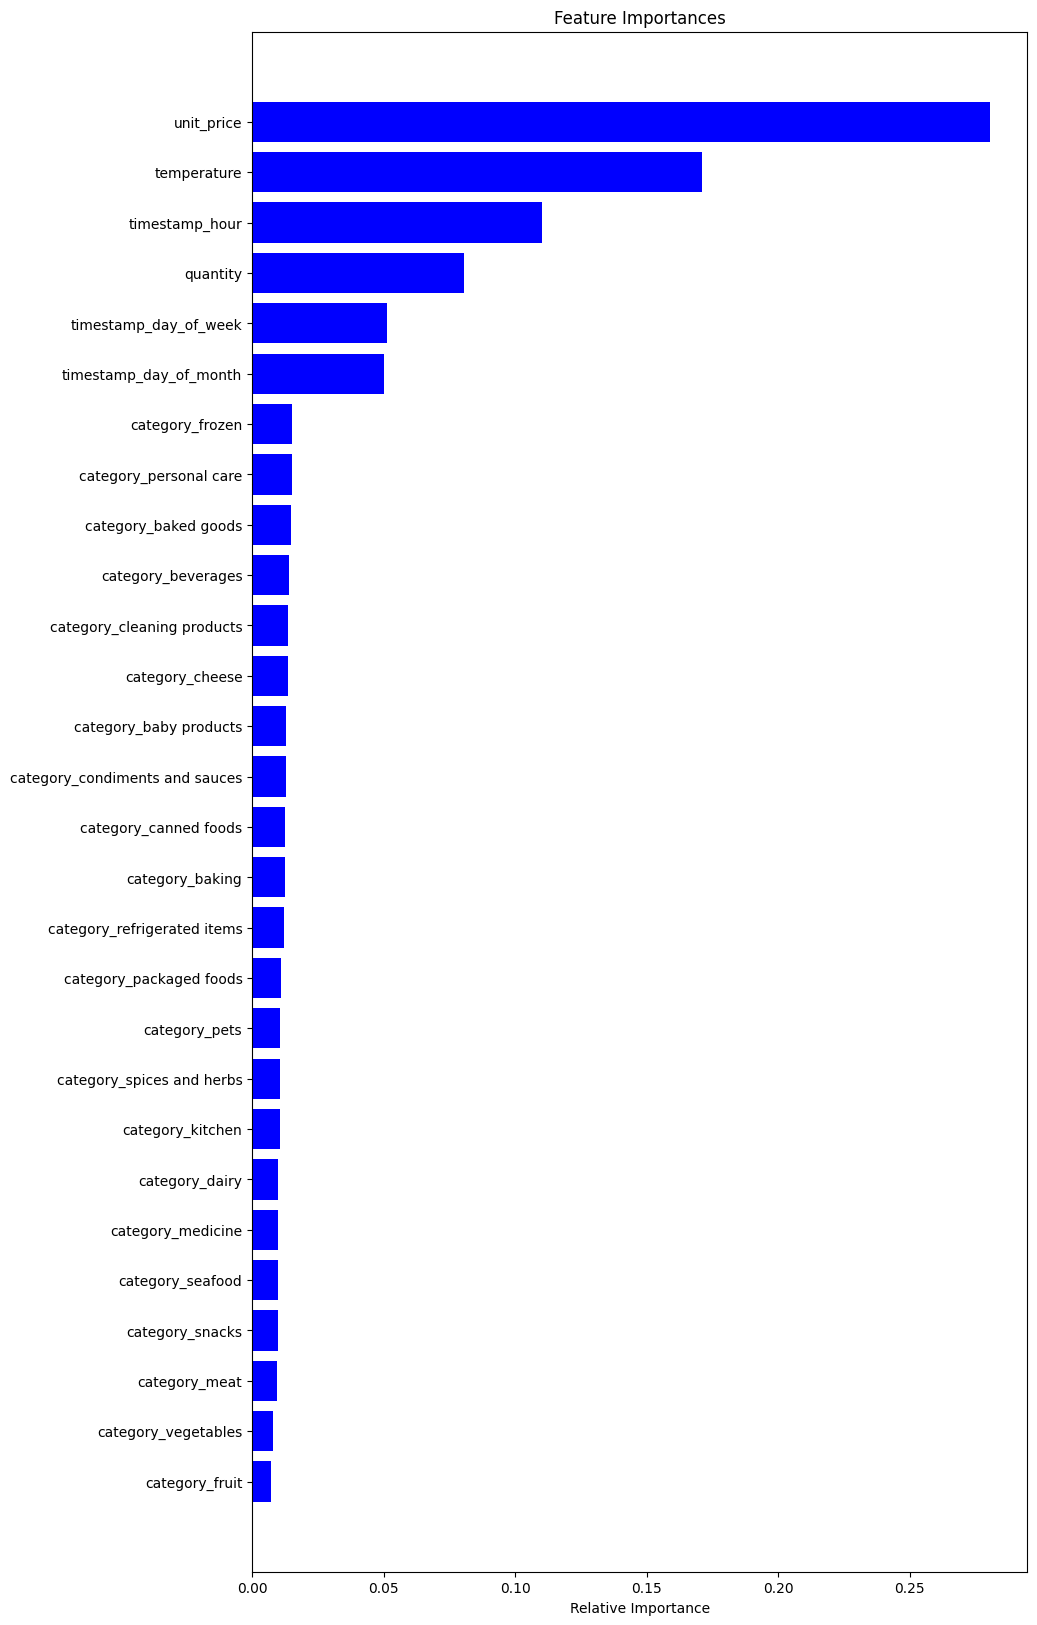

In [73]:
features = [i.split("__")[0] for i in X.columns]
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align ='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [52]:
(X.columns)

Index(['quantity', 'temperature', 'unit_price', 'timestamp_day_of_month',
       'timestamp_day_of_week', 'timestamp_hour', 'category_baby products',
       'category_baked goods', 'category_baking', 'category_beverages',
       'category_canned foods', 'category_cheese',
       'category_cleaning products', 'category_condiments and sauces',
       'category_dairy', 'category_frozen', 'category_fruit',
       'category_kitchen', 'category_meat', 'category_medicine',
       'category_packaged foods', 'category_personal care', 'category_pets',
       'category_refrigerated items', 'category_seafood', 'category_snacks',
       'category_spices and herbs', 'category_vegetables'],
      dtype='object')

In [51]:
model.feature_importances_

array([0.08066946, 0.17089356, 0.28060152, 0.05022925, 0.05130424,
       0.1102264 , 0.01294042, 0.01465327, 0.01238952, 0.0140013 ,
       0.01245563, 0.01352361, 0.01367379, 0.01292845, 0.01003082,
       0.01528303, 0.0073702 , 0.01043019, 0.00958895, 0.00987967,
       0.01106628, 0.01522373, 0.010662  , 0.01196034, 0.00979812,
       0.00972202, 0.01056933, 0.00792489])

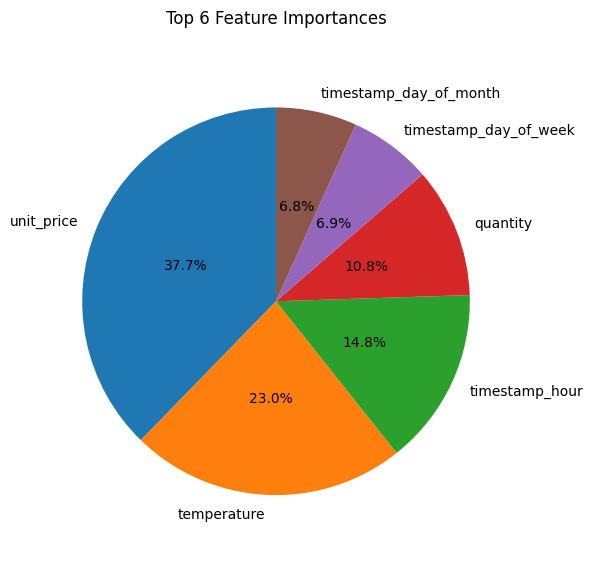

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# create a dictionary with feature importances
importances_dict = dict(zip(X.columns, model.feature_importances_))

# sort the dictionary in descending order
importances_sorted = {k: v for k, v in sorted(importances_dict.items(), key=lambda item: item[1], reverse=True)}

top_importances = list(importances_sorted.values())[:6]
top_labels = list(importances_sorted.keys())[:6]

# create a pie chart
plt.figure(figsize=(6,6))
plt.title("Top 6 Feature Importances")
plt.pie(top_importances, labels=top_labels, autopct='%1.1f%%', startangle=90, pctdistance=0.5)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [58]:
np.argsort(model.feature_importances_)[0:6]

array([16, 27, 18, 25, 24, 19], dtype=int64)

In [55]:
X.columns[0:6]

Index(['quantity', 'temperature', 'unit_price', 'timestamp_day_of_month',
       'timestamp_day_of_week', 'timestamp_hour'],
      dtype='object')

In [60]:
len(X.columns)

28

In [61]:
len(model.feature_importances_)

28

Below are the features that are most important in predicting the stock levels.

In [86]:
list_of_features = list(zip(X.columns, model.feature_importances_))
sorted_values = sorted(list_of_features, key=lambda x: x[1], reverse = True)[0:6]

# Print the sorted list
print(sorted_values)

[('unit_price', 0.2806015244343718), ('temperature', 0.1708935577426962), ('timestamp_hour', 0.11022639687135204), ('quantity', 0.08066946272475332), ('timestamp_day_of_week', 0.05130423557658695), ('timestamp_day_of_month', 0.05022924854613638)]


# Conclusion:
The features that are important to predict the stock levels of products are :
1. Unit price of the product
2. Temperature details obtained from sensor storage temperature dataset also plays a vital role
3. The time of the day also helps in predicting stock levels.
4. Followed by quantity of products that were sold.

Different Categories of products doesn’t play any important role
